# Singular Value Decomposition vs. Support Vector Machines: A Comparative Study for Handwritten Digit Recognition Using the MNIST Dataset

**Project Title:** "Singular Value Decomposition vs. Support Vector Machines: A Comparative Study for Handwritten Digit Recognition Using the MNIST Dataset"

**Project Description:**

This exciting project involves the development and implementation of a unique algorithm for handwritten digit recognition using Singular Value Decomposition (SVD) and the **MNIST** dataset. The MNIST dataset, a large database of handwritten digits, will serve as both training and testing data for the algorithm, with the ultimate goal of creating a robust and accurate recognition system.

The project will commence with the preprocessing of the MNIST images to ensure they are suitable for analysis. Following this, SVD, a powerful matrix factorization technique, will be applied to extract key features from the images. These features will then be used to train a classifier, which will be capable of recognizing handwritten digits in new, unseen images from the MNIST dataset.

In the second phase of the project, the accuracy of the SVD-based algorithm will be evaluated and compared with that of a model using Support Vector Machines (SVM), a well-established machine learning method for image classification. Both models will be tested on the same subset of the MNIST dataset, and their performances will be compared based on metrics such as accuracy, precision, recall, and F1 score.

This project offers a practical application of advanced mathematical techniques and a valuable comparison between two different approaches to image classification. The insights gained from this project could contribute to the ongoing development of more effective and efficient handwritten digit recognition systems.

In essence, this project is a comprehensive exploration of the application of SVD and SVM in handwritten digit recognition using the MNIST dataset. It provides a unique opportunity to understand the relative strengths and weaknesses of these two approaches, potentially paving the way for future advancements in the field of image recognition.

**Dataset**: [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

**Author:** [Vladislav Polyakov](https://github.com/VladekQ)

# Project

## Imports & EDA

In [1]:
import numpy as np
import seaborn as sns
import time
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
import warnings as w
w.filterwarnings('ignore')

Reading the data

In [2]:
data = np.load('mnist.npz')
X_test, X_train, y_train, y_test = data['x_test'], data['x_train'], data['y_train'], data['y_test']

In [3]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (60000, 28, 28)
y_train:  (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


We have a 60 thousands pictures for the training and 10 thousands pictures for testing

In [4]:
print('Shape of one item: ')
print(X_train[0].shape)

Shape of one item: 
(28, 28)


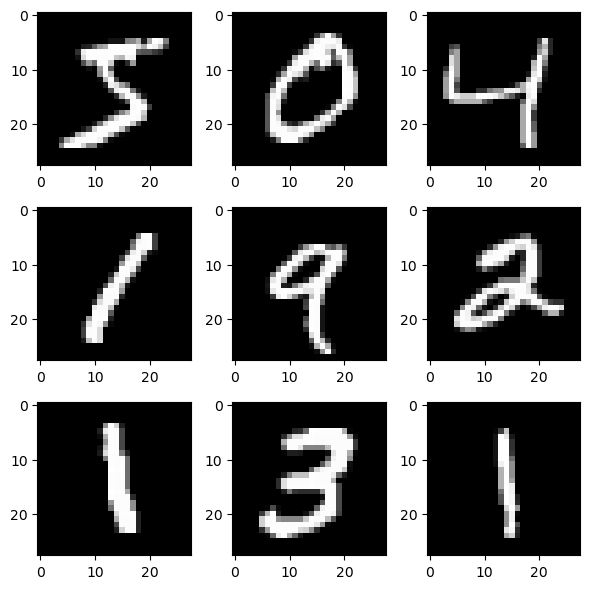

In [5]:
plt.figure(figsize = (6, 6))
a, b = 3, 3
for i in range(a * b):
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
plt.tight_layout()
plt.show()

In [6]:
y_train[:9]

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=uint8)

## Support Vectors Machine Approach

Now our data is 3-dimensional of shape (number of images, n_pixels, n_pixels). 

To work with SVD and SVM we need to flatten the images by turning each of them into an array of shape (n_pixels x n_pixels, ).

In [7]:
print('Shape of unflattened train data:', X_train.shape)
print('Shape of unflattened item:', X_train[0].shape)

Shape of unflattened train data: (60000, 28, 28)
Shape of unflattened item: (28, 28)


In [8]:
def flatten_image(X):
    return X.reshape((X.shape[0]*X.shape[1]))

X_train_flat = np.array([flatten_image(img) for img in X_train])
X_test_flat = np.array([flatten_image(img) for img in X_test])

In [9]:
print('Shape of flattened train data:', X_train_flat.shape)
print('Shape of flattened item:', X_train_flat[0].shape)

Shape of flattened train data: (60000, 784)
Shape of flattened item: (784,)


PCA works best when the data is **scaled**, so let's scale our data. I will use [StandartScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for scaling. 

Note, that scaling replaces a collection of vectors x by the collection of the vectors $x' = (x-M)/D$, where:
- $M$ is the mean vector of the sample, 
- $D$ is the vector of standard deviations of all components of the vectors, and the division is component-wise. 

So, the scaled collection has the same size as the original one, and each column has 0 mean and unit standard deviation.

**Why shoud we use a scaled data for best PCA implemenation? Let me show you an example.**

*Dimensional reduction using PCA consists of finding the features that maximize the variance. If one feature varies more than the others only because of their respective scales, PCA would determine that such feature dominates the direction of the principal components.*

*Let me inspect the first PCA component of the sample and show weights of every feature without scaling and with scaling*

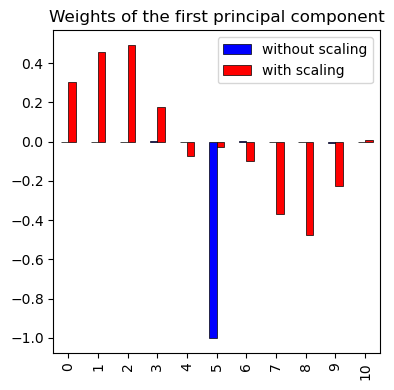

In [10]:
import pandas as pd

sample = np.array([[1, 2, 3, 4, 5, 500, 5, 4, 3, 2, 1],
                   [4, 6, 7, 4, 3, 800, 4, 3, 2, 3, 2],
                   [1, 1, 1, 4, 5, 705, 4, 7, 8, 3, 1],
                   [5, 5, 3, 2, 3, 503, 6, 7, 4, 1, 3],
                   [3, 3, 2, 1, 3, 907, 5, 6, 7, 4, 1],
                   [5, 4, 3, 3, 4, 900, 5, 8, 6, 5, 4],
                   [3, 3, 4, 3, 4, 567, 4, 5, 6, 4, 3],
                   [4, 4, 2, 1, 2, 677, 5, 5, 4, 3, 1],
                   [7, 6, 5, 4, 5, 800, 4, 5, 4, 2, 1]])

y_sample = np.array([1, 2, 2, 1, 3, 3, 1, 2, 3])

unscaled_data = sample.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample.copy())

pca = PCA(n_components=5, random_state=42).fit(unscaled_data)
scaled_pca = PCA(n_components=5, random_state=42).fit(scaled_data)

unscaled_data_transformed = pca.transform(unscaled_data)
scaled_data_transformed = scaled_pca.transform(scaled_data)

# Plot the weights of first component
first_pca_component = pd.DataFrame(
    pca.components_[0], 
    index=[_ for _ in range(len(pca.components_[0]))], 
    columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", 
    figsize=(4, 4), 
    color=['blue', 'red'], 
    ec='black', 
    linewidth=0.5
)

_ = plt.tight_layout()

Okay, it's clear. Let's continue. Now we are scaling our data.

In [11]:
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

**PCA implementation**

In [12]:
# Copying out training data for memory usage calculations
X_train_flat_copy = X_train_flat.copy()

pca = PCA(n_components=128, random_state=42)
X_train_flat = pca.fit_transform(X_train_flat)
X_test_flat = pca.transform(X_test_flat)

In [13]:
print('Shape of the Training Data after PCA:', X_train_flat.shape)
print('Shape of the Testing Data after PCA:', X_test_flat.shape)

Shape of the Training Data after PCA: (60000, 128)
Shape of the Testing Data after PCA: (10000, 128)


Let's measure the memory usage of the training data before and after PCA

In [14]:
def memory_size_mb(array):
    return array.size * array.itemsize / 1024 / 1024

print("Memory size of the 'compressed' data X_train_flat: {:.2f} MB"
      .format(memory_size_mb(X_train_flat)))
print("Memory size of the original data X_train_flat: {:.2f} MB"
      .format(memory_size_mb(X_train_flat_copy)))

print("Ratio of the memory used for compressed data and for the original data (X_train_flat): {:.1f}%"
      .format(memory_size_mb(X_train_flat)/memory_size_mb(X_train_flat_copy)*100))

Memory size of the 'compressed' data X_train_flat: 58.59 MB
Memory size of the original data X_train_flat: 358.89 MB
Ratio of the memory used for compressed data and for the original data (X_train_flat): 16.3%


Memory consumed by compressed data is 84% (100%-16% = 84%) less than memory consumed by original data

In [15]:
del X_train_flat_copy

**Now, we use SVM with linear kernel to make classification.**

In [16]:
%%time

clf = LinearSVC(random_state=42)
t1 = time.perf_counter()
clf.fit(X_train_flat, y_train)
t2 = time.perf_counter()
clf_training_time = t2 - t1

CPU times: total: 2min 11s
Wall time: 2min 10s


In [17]:
print('LinearSVC training worktime: {:.0f} seconds'.format(clf_training_time))

LinearSVC training worktime: 131 seconds


Now, let us make the predictions and calculate the accuracy, that is, the ratio of the true predictions to the test sample size.  Using [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) as the quality metric here.

$$accuracy(y\_true, y\_pred) = \frac{1}{n}\sum_{i=1}^n [y\_true_i=y\_pred_i],$$ where $[a=b]=1$, if $a=b$, and $0$ otherwise.

At the same time i will use other metrics like **precision, recall and f1-score**

In [18]:
t1 = time.perf_counter()
y_pred_svm = clf.predict(X_test_flat)
t2 = time.perf_counter()
clf_prediction_time = t2 - t1

print('LinearSVC prediction worktime: {:.0f} seconds'.format(clf_prediction_time))

acc = accuracy_score(y_pred_svm, y_test)
print("Test accuracy: {:.2f}%".format(acc*100))

prec = precision_score(y_pred_svm, y_test, average='weighted')
print("Test precision: {:.2f}%".format(prec*100))

rec = recall_score(y_pred_svm, y_test, average='weighted')
print("Test recall: {:.2f}%".format(rec*100))

f1 = f1_score(y_pred_svm, y_test, average='weighted')
print("Test F1 score: {:.2f}%".format(f1*100))

LinearSVC prediction worktime: 0 seconds
Test accuracy: 90.79%
Test precision: 90.92%
Test recall: 90.79%
Test F1 score: 90.84%


In [19]:
report = classification_report(y_test, y_pred_svm, target_names=[str(i) for i in clf.classes_])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.91      0.86      0.89      1032
           3       0.88      0.89      0.89      1010
           4       0.91      0.93      0.92       982
           5       0.87      0.84      0.86       892
           6       0.93      0.95      0.94       958
           7       0.91      0.92      0.91      1028
           8       0.87      0.84      0.86       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



We can see that numbers 3, 5 and 8 caught some problems for the model to recognize them. It happens because these number are very similar if we looking at the pixels, but for the man it's easy to recognize them right.

But overall, the model did a good job of recognizing all the numbers.

**Actual/Prediction Heatmap**

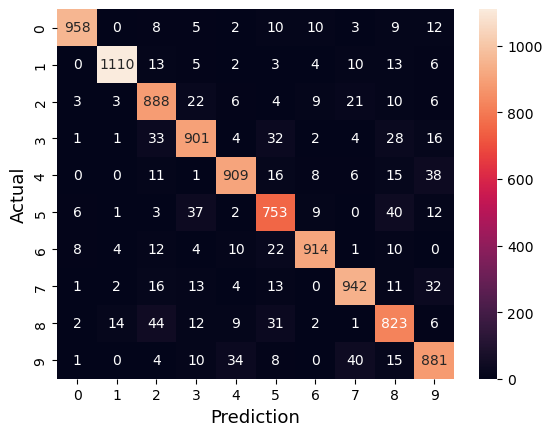

In [20]:
true_pred = pd.DataFrame(y_test, columns=['y_test']).join(pd.Series(y_pred_svm, name='y_pred'))
preds_df = pd.DataFrame(index=clf.classes_)

for number in clf.classes_:
    preds_df = preds_df.join(
        pd.Series(
            true_pred[true_pred['y_test'] == number]['y_pred'].value_counts().sort_index(),
            name=number)
    )
    
preds_df = preds_df.fillna(0)

sns.heatmap(preds_df, 
            annot=True,
            fmt='g')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
# plt.title('Confusion Matrix',fontsize=17)
plt.show()

As we can see, the model confused some numbers, here is a sample list:

- (0) Zero was practically not confused with anything.
- (1) The One was also was not confused with anything.
- (2) Two was most often confused with three (3) and seven (7).
- (3) Three was most often confused with two (2), five (5), and eight (8)
- (4) Four was most often confused with nine (9)
- (5) Five was most often confused with three (3) and eight (8)
- (6) Six was most often confused with five (5)
- (7) Seven was most often confused with nine (9)
- (8) Eight was most often confused with two (2) and five (5)
- (9) Nine was most often confused with four (5) and seven (7)

**Confusion Matrix**

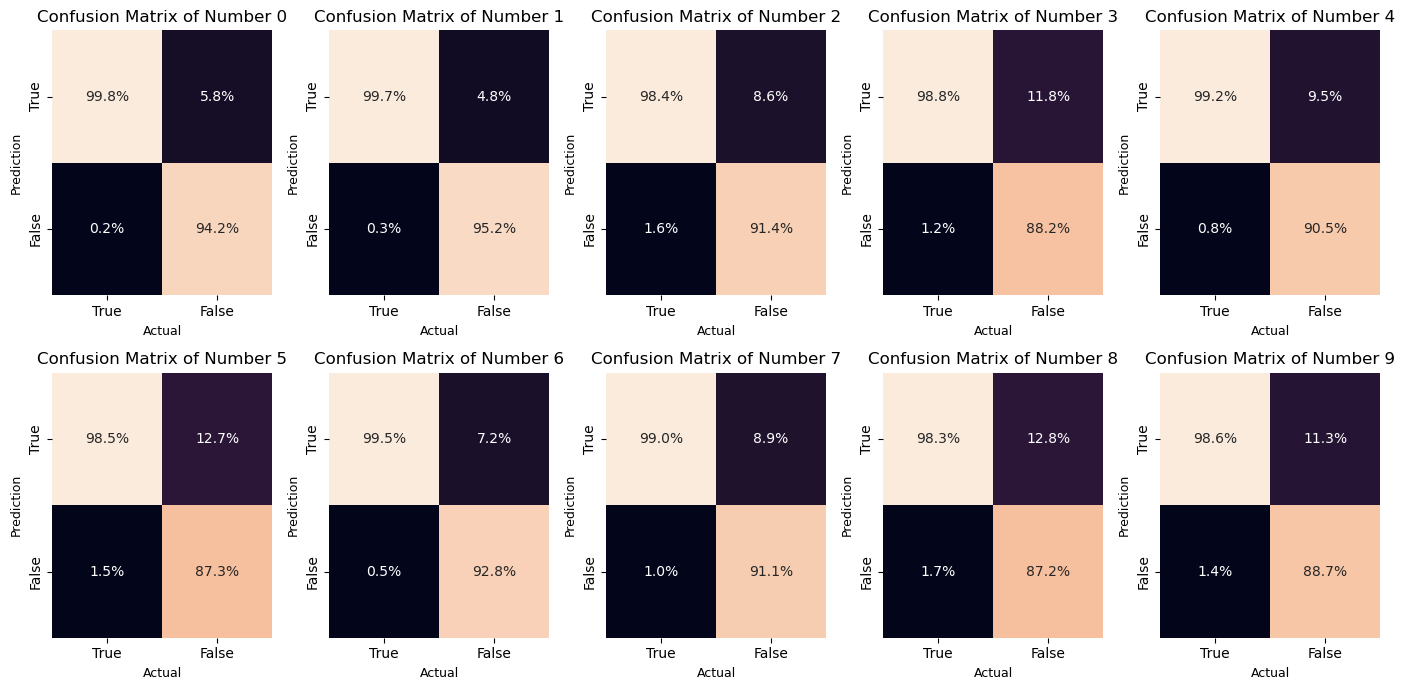

In [21]:
cm = multilabel_confusion_matrix(y_test, y_pred_svm)

def plot_conf_matrix(cm_n, number, axs_row, axs_col):
    sns.heatmap(cm_n, 
                annot=True,
                fmt='.1f', 
                xticklabels=['True','False'],
                yticklabels=['True','False'],
                ax=axs[axs_row][axs_col],
                cbar=False)
    axs[axs_row][axs_col].set_ylabel('Prediction',fontsize=9)
    axs[axs_row][axs_col].set_xlabel('Actual',fontsize=9)
    axs[axs_row][axs_col].set_title(f'Confusion Matrix of Number {number}',fontsize=12)


fig, axs = plt.subplots(2, 5, figsize=(14, 7))

k = 0
for i in range(2):
    for j in range(5):
        plot_conf_matrix(cm[k] / sum(cm[k]) * 100, k, i, j)
        for t in axs[i][j].texts: t.set_text(t.get_text() + "%")
        k += 1
        
plt.tight_layout()

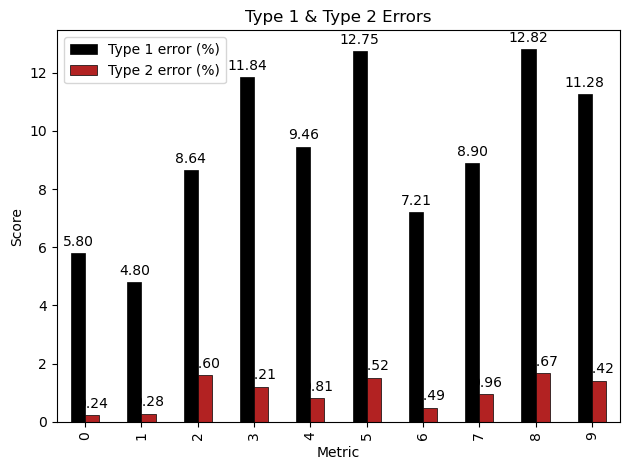

In [22]:
error_types = [((cm[k] / sum(cm[k]) * 100)[:, 1][0], (cm[k] / sum(cm[k]) * 100)[:, 0][1]) for k in range(len(cm))]

errors_clf = pd.DataFrame(
    data=error_types,
    index=clf.classes_,
    columns=['Type 1 error (%)', 'Type 2 error (%)']
)

errors_clf.sort_values(by='Type 1 error (%)', ascending=False)

errors_bar = errors_clf.plot.bar(
    xlabel='Metric',
    ylabel='Score',
    title='Type 1 & Type 2 Errors',
    color=['black', 'firebrick'],
    ec='black',
    linewidth=0.5
)
plt.legend(loc='upper left')
errors_bar.bar_label(
    errors_bar.containers[0],
    fmt='%.2f',
    padding=3
);
errors_bar.bar_label(
    errors_bar.containers[1],
    fmt='%.2f',
    padding=3
);
plt.tight_layout()

In [23]:
errors_clf.sort_values(by='Type 1 error (%)', ascending=False)

,Type 1 error (%),Type 2 error (%)
8,12.817797,1.667403
5,12.746234,1.521287
3,11.839530,1.214079
9,11.278953,1.421117
4,9.462151,0.811472
7,8.897485,0.959179
2,8.641975,1.595038
6,7.208122,0.488075
0,5.801377,0.244907
1,4.802744,0.282998


The most problematic for LinearSVC in terms of type I errors are numbers 8, 5, 3, and 9. It is because they are very similar in pixels.

**So let's try another approach with Singular Value Decomposition and then compare the results**

## Singular Value Decomposition Approach

Now let's try another approach explained [here](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) in Section 3. 

For each digit, we create a new matrix $A$ whose columns are flattened images of this digit. The first several (say, 10) columns of the matrix $U$ from SVD decomposition of $A$ represent a collection of "typical" images of this digit. Given an unrecognized flatten image, among average typical flattened images we find the closets one. Its target value is considered as a prediction for the target of the unrecognized image.

SVD of a matrix $A$ is a decomposition:
$A = U \Sigma V^T,$ where $U$ and $V$ are orthogonal matrices. In this method we will be utilizing some properties of SVD.

Let's create a function **getSingularVectorsLeft** to get the N left singular vectors from orthogonal matrix $U$ using `svd` function from NumPy Linalg.

In [24]:
def getSingularVectorsLeft(matrix, number=25): # let's take first 10 numbers
    U, s, VT = svd(matrix)
    return U[:, :number]

Then we can create a function that will return N left singular vectors from orthogonal matrix $U$ for the number that we want

In [25]:
def getSingularImage(X_train, y_train, number):
    select_images = X_train[[y == number for y in y_train]]
    A = []
    for image in select_images:
        image = flatten_image(image)
        A.append(image)

    A = np.array(A).T
    left_basis = getSingularVectorsLeft(A)
    return left_basis

Let's try it on Zero

In [26]:
left_basis = getSingularImage(X_train, y_train, 0)

left_basis.shape

(784, 25)

In [27]:
print(left_basis[0])
print(left_basis[1])
print(left_basis[3])
print('And so on...')

[ 0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0. -0.  0. -0.
  0. -0.  0.  0. -0.  0. -0.]
[-2.22044605e-16 -2.77555756e-17  8.32667268e-17  0.00000000e+00
  3.46944695e-17  4.85722573e-17  1.94289029e-16  6.59194921e-17
 -8.32667268e-17  3.46944695e-17 -6.93889390e-18  3.12250226e-17
  6.93889390e-17  7.63278329e-17 -8.32667268e-17  6.93889390e-17
  0.00000000e+00 -2.77555756e-17 -4.16333634e-17  1.90819582e-17
  6.93889390e-18  2.42861287e-17 -2.08166817e-16  2.60208521e-17
 -8.67361738e-17]
[ 0.00000000e+00  1.11022302e-16  5.55111512e-17 -1.66533454e-16
 -1.64798730e-17 -6.67868538e-17  1.38777878e-16  4.33680869e-17
 -2.77555756e-17  1.38777878e-17 -2.08166817e-17  3.81639165e-17
 -8.32667268e-17  6.24500451e-17 -2.77555756e-17  4.16333634e-17
  1.38777878e-17 -2.77555756e-17 -1.38777878e-17 -1.04083409e-17
 -2.08166817e-17 -6.93889390e-18 -1.38777878e-17  1.51788304e-17
  3.81639165e-17]
And so on...


Now let's see what we get

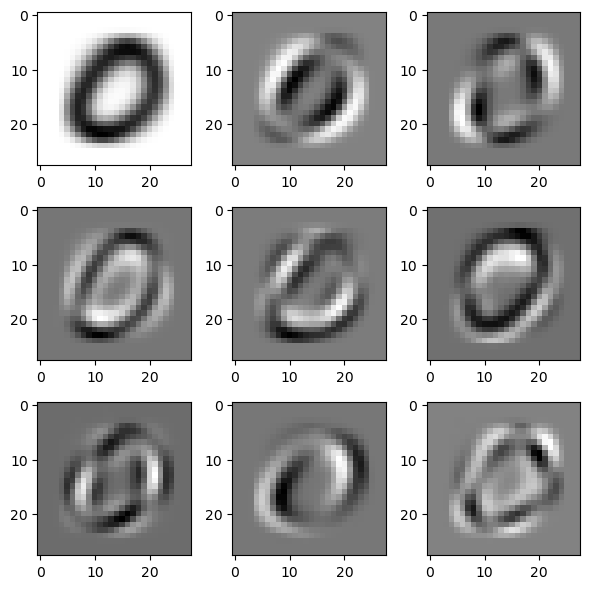

In [28]:
#singular images
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):
    plt.subplot(b, a, i+1)
    img = left_basis[:, i].reshape(28, 28)
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

***The left singular vectors*** $U_k$ ***form an orthonormal basis in the imagespace of a digit, and are referred to as a "singular image"***

***Each column of the matrix*** $U_k$ ***displays the most frequently occurring pictures in the dataset, representing the target number. And the first column of the matrix*** $U_k$ ***is a collection of the most frequently occurring pictures that display the target number***

Now let's move on and obtain singular images for all numbers. The matrices $U_k$ from  [the article](https://technodocbox.com/3D_Graphics/77509408-Handwritten-digit-classification-and-reconstruction-of-marred-images-using-singular-value-decomposition.html) are represented as `number_basis_matrices[k]`.

In [29]:
t1 = time.perf_counter()
number_basis_matrices = [getSingularImage(X_train, y_train, i) 
                         for i in np.unique(y_train)]
t2 = time.perf_counter()
number_basis_matrices_time = t2 - t1

Let's see what is the most common pictures of all numbers.

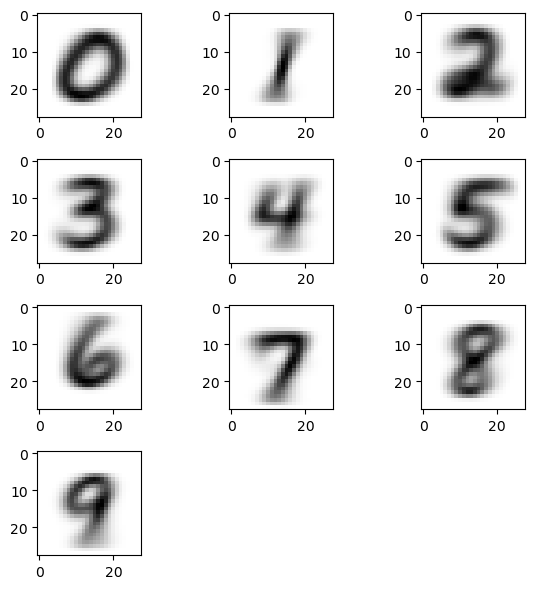

In [30]:
plt.figure(figsize=(6,6))
a, b = 3, 4
for i in range(10):
    plt.subplot(b, a, i+1)
    img = number_basis_matrices[i][:, 0].reshape(28, 28)
    plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [31]:
dim = number_basis_matrices[0].shape[0]

In [32]:
dim

784

Now let's calculate the new projection matrix for each $U_k$ by the formula to apply later in testing:
$pr = (I - U_k \cdot U_{k}^{T})$.

In [33]:
t1 = time.perf_counter()
numeric_values = [np.identity(number_basis_matrices[x].shape[0]) -
                  np.matmul(number_basis_matrices[x], number_basis_matrices[x].T)
                  for x in np.unique(y_train)]
t2 = time.perf_counter()
numeric_values_time = t2 - t1

In [34]:
svd_training_time = number_basis_matrices_time + numeric_values_time

In [35]:
print('SVD training worktime: {:.0f} seconds'.format(svd_training_time))

SVD training worktime: 15 seconds


Implementing function utilizing `numeric_values` matrices to predict labels for unknown images.

Function that will predict the number will find the closest `numeric_value` to the value that is passed to the function by using `np.linalg.norm` and matrices muliplication.

In [36]:
def find_closest(test_value, numeric_values):
    stacked_test = test_value.reshape(-1, 1)
    target = np.argmin([np.linalg.norm(numeric_values[x] @ stacked_test)
                        for x in range(len(numeric_values))])

    return target

***Finding array of predictions for X_test***

In [37]:
%%time

t1 = time.perf_counter()
y_pred_svd = [find_closest(X_test[i], numeric_values) for i in range(len(X_test))]
t2 = time.perf_counter()

svd_prediction_time = t2 - t1
print('SVD perdiction worktime: {:.0f} seconds'.format(svd_prediction_time))

SVD perdiction worktime: 12 seconds
CPU times: total: 1min 11s
Wall time: 11.9 s


In [38]:
acc_svd = accuracy_score(y_pred_svd, y_test)
print("Test accuracy: {:.2f}%".format(acc_svd*100))

prec_svd = precision_score(y_pred_svd, y_test, average='weighted')
print("Test precision: {:.2f}%".format(prec_svd*100))

rec_svd = recall_score(y_pred_svd, y_test, average='weighted')
print("Test recall: {:.2f}%".format(rec_svd*100))

f1_svd = f1_score(y_pred_svd, y_test, average='weighted')
print("Test F1 score: {:.2f}%".format(f1_svd*100))

Test accuracy: 95.76%
Test precision: 95.80%
Test recall: 95.76%
Test F1 score: 95.77%


In [39]:
report = classification_report(y_pred_svd, y_test, target_names=[str(i) for i in clf.classes_])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1015
           1       0.99      0.96      0.98      1171
           2       0.94      0.96      0.95      1015
           3       0.95      0.95      0.95      1005
           4       0.97      0.97      0.97       981
           5       0.93      0.96      0.95       865
           6       0.98      0.97      0.97       961
           7       0.94      0.96      0.95      1002
           8       0.94      0.93      0.93       983
           9       0.94      0.95      0.94      1002

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



We can see that this approach has better metrics than the previous one. At the same time, practically no numbers stand out for their reduced accuracy.

**Actual/Prediction Heatmap**

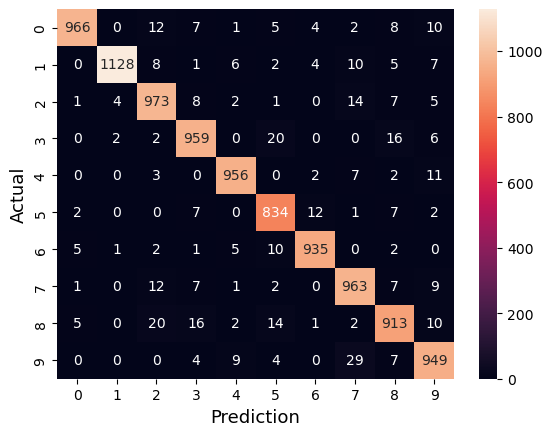

In [40]:
true_pred = pd.DataFrame(y_test, columns=['y_test']).join(pd.Series(y_pred_svd, name='y_pred'))
preds_df = pd.DataFrame(index=clf.classes_)

for number in clf.classes_:
    preds_df = preds_df.join(
        pd.Series(
            true_pred[true_pred['y_test'] == number]['y_pred'].value_counts().sort_index(),
            name=number)
    )
    
preds_df = preds_df.fillna(0)

sns.heatmap(preds_df, 
            annot=True,
            fmt='g')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
# plt.title('Confusion Matrix',fontsize=17)
plt.show()

**With this approach, confusion between similar numbers has decreased, but the underlying trend remains the same**

**Confusion Matrix**

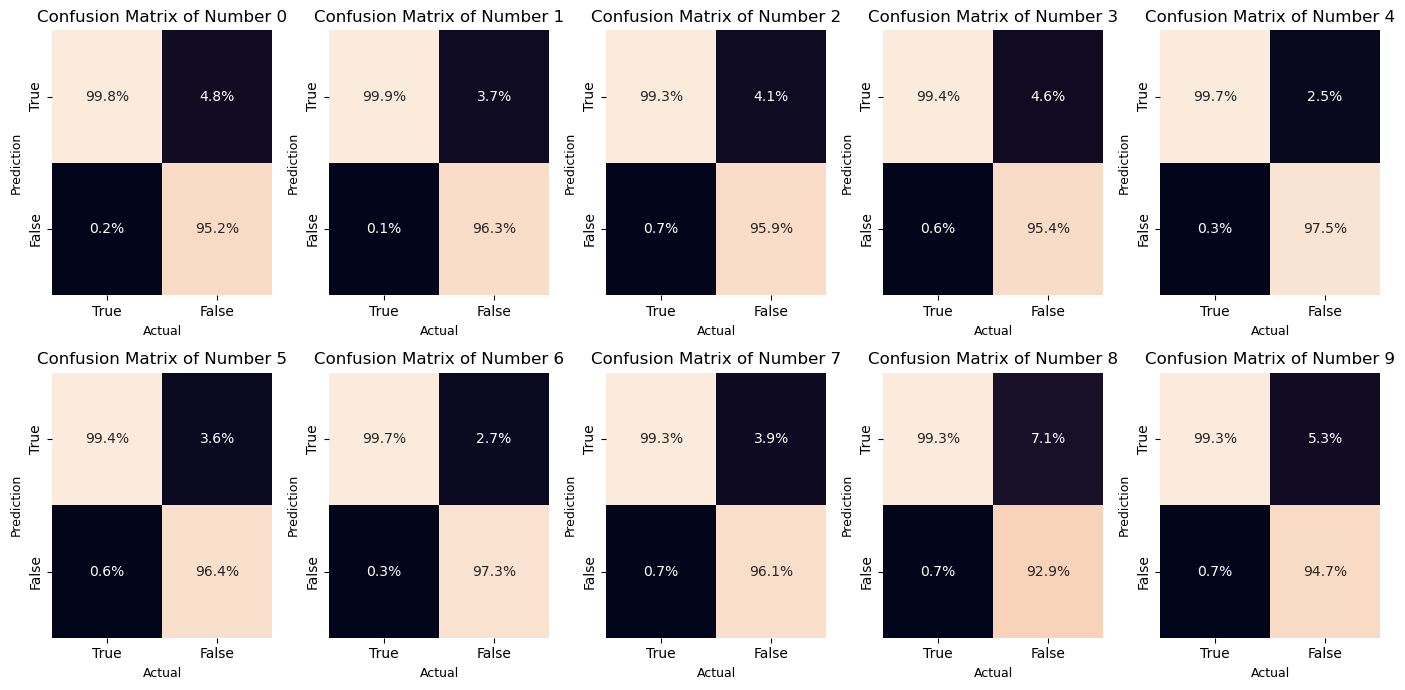

In [41]:
cm = multilabel_confusion_matrix(y_test, y_pred_svd)

def plot_conf_matrix(cm_n, number, axs_row, axs_col):
    sns.heatmap(cm_n, 
                annot=True,
                fmt='.1f', 
                xticklabels=['True','False'],
                yticklabels=['True','False'],
                ax=axs[axs_row][axs_col],
                cbar=False)
    axs[axs_row][axs_col].set_ylabel('Prediction',fontsize=9)
    axs[axs_row][axs_col].set_xlabel('Actual',fontsize=9)
    axs[axs_row][axs_col].set_title(f'Confusion Matrix of Number {number}',fontsize=12)


fig, axs = plt.subplots(2, 5, figsize=(14, 7))

k = 0
for i in range(2):
    for j in range(5):
        plot_conf_matrix(cm[k] / sum(cm[k]) * 100, k, i, j)
        for t in axs[i][j].texts: t.set_text(t.get_text() + "%")
        k += 1
        
plt.tight_layout()

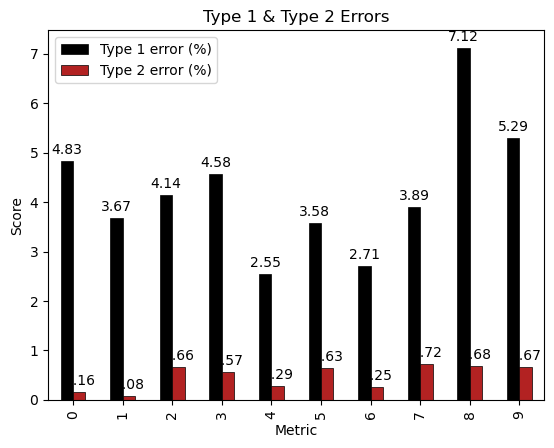

In [42]:
error_types = [((cm[k] / sum(cm[k]) * 100)[:, 1][0], (cm[k] / sum(cm[k]) * 100)[:, 0][1]) for k in range(len(cm))]

errors_svd = pd.DataFrame(
    data=error_types,
    index=clf.classes_,
    columns=['Type 1 error (%)', 'Type 2 error (%)']
)

errors_svd.sort_values(by='Type 1 error (%)', ascending=False)

errors_bar = errors_svd.plot.bar(
    xlabel='Metric',
    ylabel='Score',
    title='Type 1 & Type 2 Errors',
    color=['black', 'firebrick'],
    ec='black',
    linewidth=0.5
)
plt.legend(loc='upper left')
errors_bar.bar_label(
    errors_bar.containers[0],
    fmt='%.2f',
    padding=3
);
errors_bar.bar_label(
    errors_bar.containers[1],
    fmt='%.2f',
    padding=3
);

In [43]:
errors_svd.sort_values(by='Type 1 error (%)', ascending=False)

,Type 1 error (%),Type 2 error (%)
8,7.121058,0.676500
9,5.289421,0.666815
0,4.827586,0.155815
3,4.577114,0.566982
2,4.137931,0.656650
7,3.892216,0.722383
1,3.672075,0.079284
5,3.583815,0.634921
6,2.705515,0.254453
4,2.548420,0.288280


Thanks to the singular value decomposition, we have significantly reduced the error of the first and second types

## Comparing Results

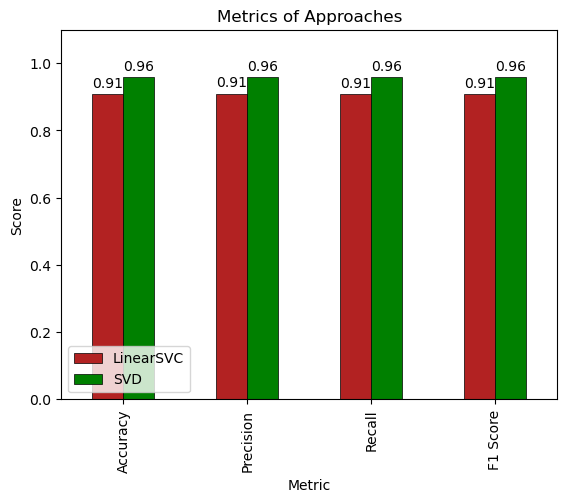

In [44]:
results = pd.DataFrame(
    {
        'LinearSVC': [acc, prec, rec, f1],
        'SVD': [acc_svd, prec_svd, rec_svd, f1_svd]
    },
    index = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
)

results_bar = results.plot.bar(
    xlabel='Metric',
    ylabel='Score',
    title='Metrics of Approaches',
    color=['firebrick', 'green'],
    ec='black',
    linewidth=0.5,
    ylim=[0, 1.1]
)
plt.legend(loc='lower left')
results_bar.bar_label(
    results_bar.containers[0],
    fmt='%.2f',
    padding=3
);
results_bar.bar_label(
    results_bar.containers[1],
    fmt='%.2f',
    padding=3
);

In [45]:
results

,LinearSVC,SVD
Accuracy,0.907900,0.957600
Precision,0.909239,0.957971
Recall,0.907900,0.957600
F1 Score,0.908359,0.957682


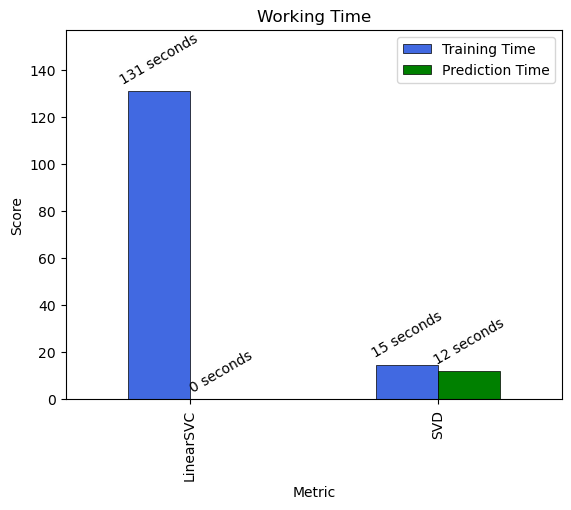

In [46]:
working_time_df = pd.DataFrame(
    {
        'LinearSVC': [clf_training_time, clf_prediction_time],
        'SVD': [svd_training_time, svd_prediction_time]
    },
    index = ['Training Time', 'Prediction Time']
)

worktime_bar = working_time_df.T.plot.bar(
    xlabel='Metric',
    ylabel='Score',
    title='Working Time',
    color=['royalblue', 'green'],
    ec='black',
    linewidth=0.5,
    ylim=[0, max([clf_training_time, clf_prediction_time, svd_training_time, svd_prediction_time])*1.2]
)
worktime_bar.bar_label(
    worktime_bar.containers[0],
    fmt='%.0f seconds',
    padding=3,
    rotation=30
);
worktime_bar.bar_label(
    worktime_bar.containers[1],
    fmt='%.0f seconds',
    padding=3,
    rotation=30
);

# Conclusion

In conclusion, the project **"Singular Value Decomposition vs. Support Vector Machines: A Comparative Study for Handwritten Digit Recognition Using the MNIST Dataset"** provided a comprehensive analysis of the performance of two popular machine learning techniques in the context of handwritten digit recognition. The Singular Value Decomposition (SVD) method demonstrated superior performance over the Support Vector Machines (SVM) method, achieving higher scores in all evaluated metrics. Specifically, SVD achieved an accuracy, precision, recall, and F1 score of 0.96, outperforming SVM which scored 0.91 in all these metrics. 

Moreover, SVD showed a significant advantage in terms of training and prediction time, taking only about 27 seconds to train and predict compared to SVM's 131 seconds. 

This study therefore suggests that SVD is a more effective and efficient choice for handwritten digit recognition tasks, offering a more reliable and accurate classification of numbers in images while requiring less training time. However, it is important to consider other factors such as scalability and generalizability to other datasets when selecting a machine learning method for a specific application.

# Appendix: Recognizing numbers from own dataset

I made my own dataset of white numebr on a black background. Let's see how SVM and SVD will recognize them.

In [47]:
from scipy import misc
from PIL import Image

In [48]:
own_pics = pd.DataFrame()

In [49]:
def my_own_pic(img_name, right_answer):
    global own_pics
    image = Image.open(f'samples_hand/{img_name}').convert('L')
    new_image = image.resize((28, 28))
    custom_ = np.array(new_image)
    
    custom = flatten_image(custom_).reshape(1, -1)
    custom = scaler.transform(custom)
    custom = pca.transform(custom)
    
    own_pics = pd.concat(
        [
            own_pics,
            pd.DataFrame(
                {
                    'True Label': [right_answer],
                    'LinearSVC Label': [clf.predict(custom)[0]],
                    'SVD Label': [find_closest(custom_, numeric_values)]
                }
            )
        ]
    )
    return new_image, clf.predict(custom)[0], find_closest(custom_, numeric_values)

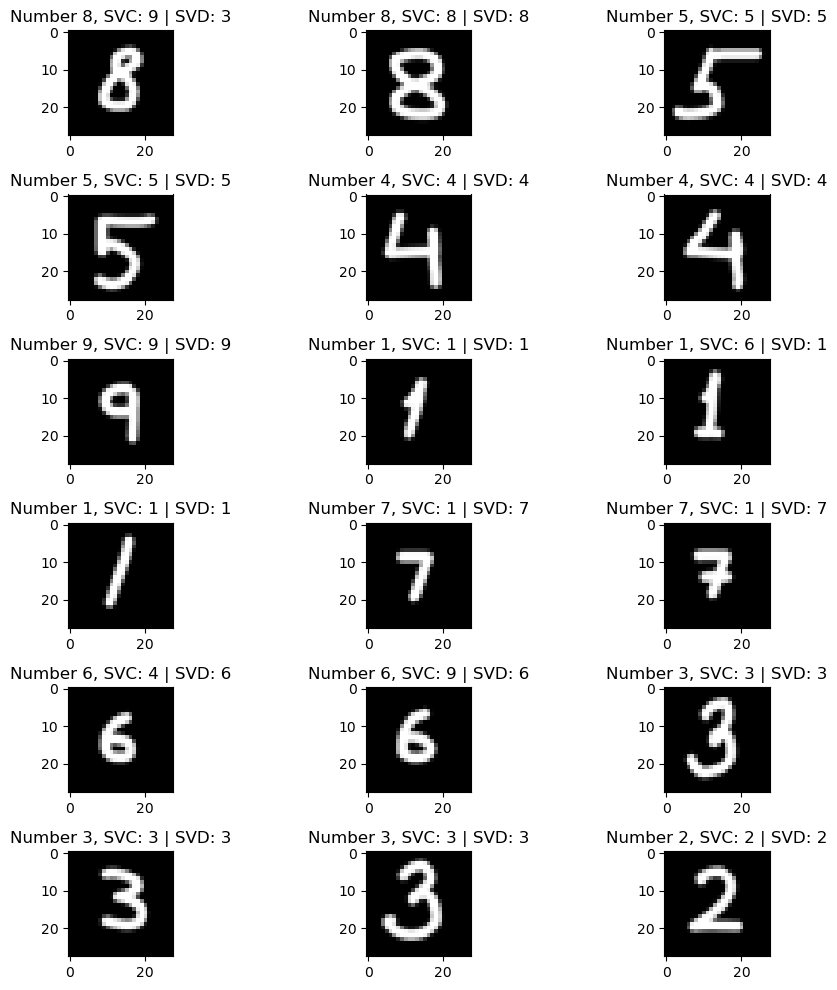

In [50]:
import os

fig, axs = plt.subplots(6, 3, figsize=(10, 10))
img_names = [img_name for img_name in os.listdir('samples_hand/')]
right_answers = [8, 8, 5, 5, 4, 4, 9, 1, 1, 1, 7, 7, 6, 6, 3, 3, 3, 2]
k = 0
for i in range(6):
    for j in range(3):
        img_to_plot, svc_answer, svd_answer = my_own_pic(img_names[k], right_answers[k])
        axs[i][j].imshow(img_to_plot, cmap='gray')
        axs[i][j].set_title(f'Number {right_answers[k]}, SVC: {svc_answer} | SVD: {svd_answer}')
        k += 1
        
plt.tight_layout()

In [51]:
own_pics = own_pics.reset_index(drop=True)

In [52]:
own_pics

,True Label,LinearSVC Label,SVD Label
0,8,9,3
1,8,8,8
2,5,5,5
3,5,5,5
4,4,4,4
5,4,4,4
6,9,9,9
7,1,1,1
8,1,6,1
9,1,1,1


In [53]:
acc_svm_own = accuracy_score(own_pics['True Label'], own_pics['LinearSVC Label'])
acc_svd_own = accuracy_score(own_pics['True Label'], own_pics['SVD Label'])

In [54]:
print('Accuracy Score on own dataset by LinearSVC: {:.1f}%'.format(acc_svm_own*100))
print('Accuracy Score on own dataset by SVD: {:.1f}%'.format(acc_svd_own*100))

Accuracy Score on own dataset by LinearSVC: 66.7%
Accuracy Score on own dataset by SVD: 94.4%


**Even on your own dataset (which may not be ideal), the singular value decomposition method shows the best result**